# Explanation of data gathering pipeline
I have a Python script that takes about 1.5 days to run in entirety on my computer, which is why it's a .py script I can just leave going in a shell in the background. This is a more readable walkthrough that explains some of the decisions behind what I did and gives examples of the data at each stage.

In [1]:
import os # for file operations
import pandas
import wikipedia # gets list of all languages on wikipedia

# 0: Find the data files to download
The Wikipedia API offers a dictionary of all the languages of a Wikipedia edition that exists or used to exist. It provides both the language's abbreviation/code and name. So, my code iterates through this list:

In [2]:
langsdict = wikipedia.languages()
langsdict

{'aa': 'Qafár af',
 'ab': 'Аҧсшәа',
 'abs': 'bahasa ambon',
 'ace': 'Acèh',
 'ady': 'адыгабзэ',
 'ady-cyrl': 'адыгабзэ',
 'aeb': 'تونسي/Tûnsî',
 'aeb-arab': 'تونسي',
 'aeb-latn': 'Tûnsî',
 'af': 'Afrikaans',
 'ak': 'Akan',
 'aln': 'Gegë',
 'als': 'Alemannisch',
 'alt': 'алтай тил',
 'am': 'አማርኛ',
 'ami': 'Pangcah',
 'an': 'aragonés',
 'ang': 'Ænglisc',
 'anp': 'अङ्गिका',
 'ar': 'العربية',
 'arc': 'ܐܪܡܝܐ',
 'arn': 'mapudungun',
 'arq': 'جازايرية',
 'ary': 'الدارجة',
 'arz': 'مصرى',
 'as': 'অসমীয়া',
 'ase': 'American sign language',
 'ast': 'asturianu',
 'atj': 'Atikamekw',
 'av': 'авар',
 'avk': 'Kotava',
 'awa': 'अवधी',
 'ay': 'Aymar aru',
 'az': 'azərbaycanca',
 'azb': 'تۆرکجه',
 'ba': 'башҡортса',
 'ban': 'Basa Bali',
 'ban-bali': 'ᬩᬲᬩᬮᬶ',
 'bar': 'Boarisch',
 'bat-smg': 'žemaitėška',
 'bbc': 'Batak Toba',
 'bbc-latn': 'Batak Toba',
 'bcc': 'جهلسری بلوچی',
 'bcl': 'Bikol Central',
 'be': 'беларуская',
 'be-tarask': 'беларуская (тарашкевіца)\u200e',
 'be-x-old': 'беларуская (тарашкев

When I have the language's abbreviation `abv`, I can construct the download link for the wikipedia dump as: 

'*https://dumps.wikimedia.org/*' + `abv` + '*wiki/latest/*' + `abv` + '*wiki-latest-pages-articles.xml.bz2*'

Once I download it, I store it on my computer. Then, I check to see if the file is already present locally before re-downloading. This way I don't need to keep stressing Wikipedia's server each time I run my program. Some wikipedias are closed/no longer maintained and throw an error if I try to download, so I just skip those languages. Also, I deem languages as too small if their raw dump file size is less than 1MB, I'll discuss more why later.

# 1: Download raw wikipedia XML files
The script downloads these automatically, they come in a compressed .xml.bz format.

In [3]:
dumpspath = './datagather/dumps/' # where I'm storing the raw files
dumpsraw = dict()
for f in os.listdir(dumpspath):
    if f.startswith('.'): continue
    lang = f[:f.index('.')-4] # isolate just name of the language
    dumpsraw[lang] = [langsdict[lang], os.path.getsize(dumpspath + f)]

Dataframe of the languages I've gotten - 248 languages:

In [4]:
dumps = pandas.DataFrame.from_dict(dumpsraw, columns=['name', 'fsize'], orient='index')
print(dumps.shape)
dumps.head()

(248, 2)


,name,fsize
ht,Kreyòl ayisyen,13973117
li,Limburgs,14315808
ig,Igbo,2109360
tet,tetun,1222946
wuu,吴语,14397542


This is the number of bytes for these raw dump files alone, which is about 76 gigabytes:

In [35]:
dumps['fsize'].sum() 

76499174416

These are the languages I skipped for either of the reasons I mentioned:

In [5]:
excluded = [langsdict[l] for l in langsdict.keys() if l not in dumps.index]
print(len(excluded), 'languages excluded:\n', ', '.join(excluded))

206 languages excluded:
 Qafár af, bahasa ambon, адыгабзэ, адыгабзэ, تونسي/Tûnsî, تونسي, Tûnsî, Akan, Gegë, алтай тил, Pangcah, अङ्गिका, ܐܪܡܝܐ, mapudungun, جازايرية, American sign language, Atikamekw, ᬩᬲᬩᬮᬶ, žemaitėška, Batak Toba, Batak Toba, جهلسری بلوچی, беларуская (тарашкевіца)‎, беларуская (тарашкевіца)‎, روچ کپتین بلوچی, भोजपुरी, Bislama, bamanankan, بختیاری, Bráhuí, Batak Mandailing, Iriga Bicolano, Chavacano de Zamboanga, Chamoru, Choctaw, ᏣᎳᎩ, Tsetsêhestâhese, Capiceño, Nēhiyawēwin / ᓀᐦᐃᔭᐍᐏᐣ, къырымтатарджа (Кирилл)‎, qırımtatarca (Latin)‎, словѣньскъ / ⰔⰎⰑⰂⰡⰐⰠⰔⰍⰟ, Österreichisches Deutsch, Schweizer Hochdeutsch, Deutsch (Sie-Form)‎, Thuɔŋjäŋ, Dusun Bundu-liwan, ཇོང་ཁ, eʋegbe, Emiliàn, Canadian English, British English, español de América Latina, español (formal)‎, Fulfulde, meänkieli, võro, Na Vosa Vakaviti, français cadien, 赣语（简体）‎, 贛語（繁體）‎, kriyòl gwiyannen, गोंयची कोंकणी, Gõychi Konknni, 𐌲𐌿𐍄𐌹𐍃𐌺, Ἀρχαία ἑλληνικὴ, Alemannisch, Hawaiʻi, Fiji Hindi, Ilonggo, Hiri Motu, Hunsrik

But these are the ones I was able to get:

In [6]:
print(dumps.shape[0], 'languages included:\n', ', '.join(dumps['name']))

248 languages included:
 Kreyòl ayisyen, Limburgs, Igbo, tetun, 吴语, коми, الدارجة, latviešu, la .lojban., भोजपुरी, мокшень, Zeêuws, oʻzbekcha/ўзбекча, تۆرکجه, සිංහල, norsk nynorsk, português, Bahasa Melayu, अवधी, 中文, тыва дыл, svenska, башҡортса, മലയാളം, Tagalog, arpetan, slovenščina, Afrikaans, Jawa, Yorùbá, Mirandés, ગુજરાતી, Frysk, Māori, Xitsonga, sicilianu, italiano, Aymar aru, Gagauz, ꯃꯤꯇꯩ ꯂꯣꯟ, davvisámegiella, føroyskt, తెలుగు, brezhoneg, català, Адыгэбзэ, dansk, 贛語, Pälzisch, Nāhuatl, Novial, qırımtatarca, Simple English, dolnoserbski, ߒߞߏ, Oromoo, অসমীয়া, English, lumbaart, বাংলা, پنجابی, hrvatski, Nouormand, ລາວ, ଓଡ଼ିଆ, русский, 한국어, interlingua, Papiamentu, къарачай-малкъар, Кыргызча, Kotava, български, azərbaycanca, vepsän kel’, Alemannisch, Gaelg, Plattdüütsch, livvinkarjala, Soomaaliga, Piemontèis, Sunda, Ænglisc, galego, Hausa, Mìng-dĕ̤ng-ngṳ̄, کوردی, ייִדיש, emiliàn e rumagnòl, ਪੰਜਾਬੀ, авар, walon, română, Picard, kurdî, گیلکی, مصرى, suomi, မြန်မာဘာသာ, kaszëbsczi, Baha

Largest wikipedias by raw dump file size:

In [7]:
dumps.sort_values('fsize', ascending=False).head(10) # largest wikis included

,name,fsize
en,English,18267134864
de,Deutsch,5877797639
fr,français,4972442407
ru,русский,4224935955
ja,日本語,3309015603
es,español,3144443923
it,italiano,3129866871
zh,中文,2122775813
pl,polski,2024669975
pt,português,1831289660


English alone is about 18 GB! The distant second is German at about 6 GB.

Smallest file sizes that I included (since cutoff was 1MB):

In [8]:
dumps.sort_values('fsize').head(10) # smallest wikis included

,name,fsize
nqo,ߒߞߏ,1049963
jbo,la .lojban.,1074932
pdc,Deitsch,1085523
nov,Novial,1111229
mdf,мокшень,1119182
smn,anarâškielâ,1149766
lbe,лакку,1188547
tet,tetun,1222946
kbp,Kabɩyɛ,1316060
tpi,Tok Pisin,1371967


Plot of the filesizes for the languages I included. You can see most are quite small, while a few are very big.

<AxesSubplot:ylabel='Frequency'>

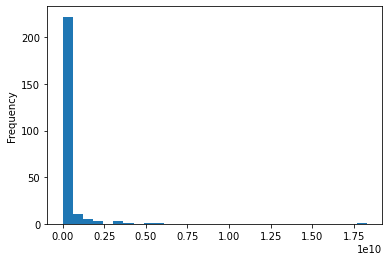

In [9]:
dumps['fsize'].plot.hist(bins=30) # many small wikis, just a few big wikis

Here is an example of Qaraqalpaqsha's raw dump file, if I manually decompress it (I don't store these anywhere, it's all handled by the extractor tool I use):

In [10]:
f = open('./datagather/kaa-raw.xml', 'r')
exdump = f.readlines()
f.close()
exdump[:20] # start of file

['<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="kaa">\n',
 '  <siteinfo>\n',
 '    <sitename>Wikipedia</sitename>\n',
 '    <dbname>kaawiki</dbname>\n',
 '    <base>https://kaa.wikipedia.org/wiki/Bas_bet</base>\n',
 '    <generator>MediaWiki 1.36.0-wmf.31</generator>\n',
 '    <case>first-letter</case>\n',
 '    <namespaces>\n',
 '      <namespace key="-2" case="first-letter">Media</namespace>\n',
 '      <namespace key="-1" case="first-letter">Arnawlı</namespace>\n',
 '      <namespace key="0" case="first-letter" />\n',
 '      <namespace key="1" case="first-letter">Sa\'wbet</namespace>\n',
 '      <namespace key="2" case="first-letter">Paydalanıwshı</namespace>\n',
 '      <namespace key="3" case="first-letter">Paydalanıwshı sa\'wbeti</namespace>\n',
 '      <namespace key="4" case="fi

In [11]:
exdump[3745:3765] # random middle part showing part of an article 

['      <sha1>j4b51cvuaoqrzh27274l7fzp3q29453</sha1>\n',
 '    </revision>\n',
 '  </page>\n',
 '  <page>\n',
 "    <title>A'jiniyaz</title>\n",
 '    <ns>0</ns>\n',
 '    <id>152</id>\n',
 '    <revision>\n',
 '      <id>43321</id>\n',
 '      <parentid>30626</parentid>\n',
 '      <timestamp>2020-05-01T08:16:04Z</timestamp>\n',
 '      <contributor>\n',
 '        <ip>185.163.26.25</ip>\n',
 '      </contributor>\n',
 '      <model>wikitext</model>\n',
 '      <format>text/x-wiki</format>\n',
 '      <text bytes="7440" xml:space="preserve">\'\'\'A\'jiniyaz Qosıbay ulı\'\'\' (a\'debiy laqabı \'\'Ziywar\'\') - XIX a\'sirdegi qaraqalpaq klassik a\'debiyatının\' en\' o\'rnekli wa\'killerinin\' biri. Ol do\'retiwshiliginde o\'zine ta\'n o\'zgeshelikke iye, og\'ada talantlı, oqımıslı, medreseni ayrıqsha tamamlag\'an aqun, ulama, ko\'rkem so\'z sheberi sıpatında basqalardan ayrılıp turatug\'ın uqıplılıq penen o\'z da\'wirinin\' progressiv idealların ju\'zege shıg\'ardı, anıq turmıs haqıyqatl

One of the languages that ultimately gets excluded is Qafár af. Here I'll read in its expanded dump file:

In [12]:
f = open('datagather/aa-raw.xml')
aaraw = f.readlines()
f.close()

In [13]:
aaraw[:20]

['<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="aa">\n',
 '  <siteinfo>\n',
 '    <sitename>Wikipedia</sitename>\n',
 '    <dbname>aawiki</dbname>\n',
 '    <base>https://aa.wikipedia.org/wiki/Main_Page</base>\n',
 '    <generator>MediaWiki 1.36.0-wmf.32</generator>\n',
 '    <case>first-letter</case>\n',
 '    <namespaces>\n',
 '      <namespace key="-2" case="first-letter">Media</namespace>\n',
 '      <namespace key="-1" case="first-letter">Special</namespace>\n',
 '      <namespace key="0" case="first-letter" />\n',
 '      <namespace key="1" case="first-letter">Talk</namespace>\n',
 '      <namespace key="2" case="first-letter">User</namespace>\n',
 '      <namespace key="3" case="first-letter">User talk</namespace>\n',
 '      <namespace key="4" case="first-letter">Wikipedia</names

In [14]:
len(aaraw)

5526

At first glance, this language's XML file has 5526 lines, which sounds like enough to at least get a good sampling of what the language looks like. But then I stripped all the XML and extra Wikipedia information off.

# 2: Remove the XML and wikipedia formatting
Wikipedia formatting is stuff like the particular templates used in the articles, the random stuff you see at the very start of the above raw XML file, etc.

In [15]:
f = open('datagather/aa.txt')
aa = f.readlines()
f.close()

Here is Qafár af (the example excluded language)'s *entire* file without the XML and extra Wikipedia formatting:

In [16]:
aa

['{"id": "1426", "revid": "2266", "url": "https://aa.wikipedia.org/wiki?curid=1426", "title": "Main page", "text": ""}\n',
 '{"id": "2105", "revid": "361", "url": "https://aa.wikipedia.org/wiki?curid=2105", "title": "Wikipedia", "text": "Wikipedia bödero kœáth amliethog e rhyδ gē gell tō un gelœga. Denn grëað zero œáthws ar ðechre di zera gentannwm hon."}\n']

As you can see, the output of the tool I used is one json object per page/article. From 5526 lines, Qafár af is left with just two pages, one of which has no text at all. The other page is just a sentence long; it seems to be a message notifying users that this wikipedia is closed and not maintained. This is why I excluded languages whose raw dump files are smaller than 1MB.

Returning to Qaraqalpaqsha, which I showed the raw dump for earlier, here is its Wikipedia with the XML and Wikipedia formatting removed:

In [17]:
f = open('datagather/kaa-extracted.txt', 'r')
kaa = f.readlines()
f.close()

In [18]:
kaa[:3]

['{"id": "16", "revid": "19", "url": "https://kaa.wikipedia.org/wiki?curid=16", "title": "Main Page", "text": ""}\n',
 '{"id": "140", "revid": "6", "url": "https://kaa.wikipedia.org/wiki?curid=140", "title": "Bas bet/Interwikis", "text": "&lt;includeonly&gt; &lt;/includeonly&gt;"}\n',
 '{"id": "148", "revid": "17", "url": "https://kaa.wikipedia.org/wiki?curid=148", "title": "A\'bdiraman O\'tepov", "text": "A\'bdiraman O\'tepov (1905-1934) - qaraqalpaq dramaturgiyasının\' tiykarın salıwshılardın\' biri. Ol talantlı dramaturg, rejissyor, aktyor, muzıkant, ko\'rnekli teatr iskeri sıpatında qaraqalpaq xalqının\' tariyxında belgili iz qaldırdı. \\nA\'.O\'tepov 1905 jılı Qon\'ıratta mayda sawdager semyasında tuwıldı. 1906 jılı a\'kesi semyası menen Aral ten\'izinin\' qubla-shıg\'ıs jag\'asına jaqın Qosjap degen jerge ko\'ship keledi ha\'m balıq o\'ndirisi ka\'sibi menen shug\'ıllana baslaydı. Bul O\'tepovtın\' semyasının\' ruslar menen jaqınlasıwına mu\'mkinshilik tuwdırdı.\\n1910 jılı ol Ni

The encoding is causing some weird display issues for some characters here, it's strange because it shows up fine in my text editor and in zsh with the `head` command. Either way, it gets corrected once it travels through the rest of my current data correction pipeline and the final file for this language which I'll show later displays fine.

The tool I'm using to go from raw dump to "clean" json items is called WikiExtractor. The current version on GitHub is not stable, but it's here: https://github.com/attardi/wikiextractor

I forked it and made a stable version here: https://github.com/soCromp/wikiextractor

I needed to use specifically this tool for another project I'm doing in another class and spent a lot of time fixing it and figuring out how to run it. It's designed specifically for processing Wikipedia data en masse and already "knows" Wikipedia formatting and how to find certain article attributes. As a result, I decided to just use it again here rather than learn how to use totally another thing like Beautiful Soup - I've used their Java library a couple years ago (jsoup) and remembered taking a while to get data cleaned like I wanted. 

The tool runs pretty quick - Afrikaans takes 4-5 minutes and English maybe 15. I also pass the text through some shell regex like `sed` at this point for a little extra cleaning.

# 3: Get the article text
The next step in the pipeline is correcting the encoding for languages that do not use latin script, which look like a series of unicode codepoints (eg `\u1324\u3124...`) after the XML and Wikipedia formatting is extracted. Then, I grab just article text from the json objects.

In [19]:
f = open('datagather/af-texts.txt')
aftexts = f.readlines()
f.close()

At this point, all the articles' texts are combined into one super long string:

In [20]:
len(aftexts)

1

Here is the start of this string for Afrikaans:

In [21]:
aftexts = aftexts[0]
print(aftexts[:400])

 AfrikaAfrika is die wêreld se tweede grootste kontinent (na Asië) in sowel oppervlakte as bevolking. Saam met die eilande beslaan dit ongeveer 30 221 532 km² wat 20,3% van die totale landoppervlakte van die aarde is en dit word bewoon deur meer as 1 miljard mense – ongeveer 'n sewende van die wêreldbevolking.Tale.Die meeste amptelike tale van Afrika is Indo-Europese tale soos Frans, Engels, Portu


As you can see, it's not perfectly clean - I still have a bug somewhere where some words are not being separated by spaces. This should start with "Afrika Afrika", not "AfrikaAfrika". Sometimes I'll also see other random things like links that managed to slip through too. 

After this step, I was planning to tokenize. I added this in and started to run the script on all the data, but disliked the results I was getting. I don't know what tool I could use to tokenize different languages since there are so many different rules and probably a lot of things I don't know about how to tokenize the languages I don't speak. So, I just took the tokenizing step out at least for now.
# 4: Cleaning to remove punctuation, extra spaces
Next, I just pass the text through a filter to remove all puntuation characters and replace sequences of multiple spaces in a row with just one space. I use a special unicode library function, unicodedata.category() to detect any unicode puntuation character in order to catch even puntuation like the Japanese period "。"

In [22]:
f = open('datagather/af2.txt')
afclean = f.readlines()
f.close()

In [23]:
afclean[0][:400]

' AfrikaAfrika is die wêreld se tweede grootste kontinent na Asië in sowel oppervlakte as bevolking Saam met die eilande beslaan dit ongeveer 30\xa0221\xa0532\xa0km² wat 203 van die totale landoppervlakte van die aarde is en dit word bewoon deur meer as 1 miljard mense ongeveer n sewende van die wêreldbevolkingTaleDie meeste amptelike tale van Afrika is IndoEuropese tale soos Frans Engels Portugees Spaans e'

Again, there is some strange encoding issue when I display it in Jupyter that is not occurring elsewhere. You can see it in the spaces between the numbers. 

# 5: Chunking and shuffling
Originally I had the idea to make each line a sentence or a certain number of words. Then I realized not all languages separate words or sentences the same way, and decided the most language-neutral way to do this would be to simply make each line 500 characters long. I refer to each line as a chunk, and simply divide the long block of text every 500 characters. I'm sure there are better ways to handle this, but I chose this simple way for now at least. Then, if there are more than 100000 chunks, I randomly sample 100000 chunks to prevent any larger languages from being overrepresented in my data. This number is somewhat arbitrary so I might revisit later. Lastly, I shuffle the chunks.

In [24]:
f = open('datagather/extracted/af.txt', encoding='utf-8')
af = f.readlines()
f.close()

First five Afrikaans chunks:

In [25]:
af[:5]

['07 en 191112 Ivan Haarburger 191214 en Sol Harris 1929Die gemeenskap het n goed ontwikkelde netwerk instellings gehad waaronder n doelmatige gemeenskapsentrum vir kultuur en opvoedingsaktiwiteite In 1965 is n groot nuwe sinagoge gebou In 1956 het die Hebreeuse gemeente Chevra Kaddisha talmoed tora en liefdadigheidsintellings saamgespan om die Verenigde Hebreeuse Instellings van Bloemfontein te vormDaar was ook onder meer n OVS provinsiale komitee van de SuidAfrikaanse Joodse Raad van Afgevaardig\n',
 ' nie en het die lyding beëindig wat ander wesens nog ervaarSiddhartha Gautama word nie as die enigste Boeddha beskou nie Die Palikanon verwys na talle vorige Boeddhas sien Lys van bekende Boeddhas terwyl die Mahayanatradisie nog baie Boeddhas van hemelse eerder as historiese oorsprong noem n Algemene geloof is dat die volgende Boeddha se naam Maitreya sal weesTheravadaBoeddhismeIn die Theravadatradisie kan n persoon ontwaak word uit die slaap van onkunde deur die ware aard van realiteit

In [26]:
f = open('datagather/extracted/en.txt', encoding='utf-8')
en = f.readlines()
f.close()

First 5 English chunks:

In [27]:
en[:5]

['e countries and the preventable deaths of several childrenMechanismAutisms symptoms result from maturationrelated changes in various systems of the brain How autism occurs is not well understood Its mechanism can be divided into two areas the pathophysiology of brain structures and processes associated with autism and the neuropsychological linkages between brain structures and behaviors The behaviors appear to have multiple pathophysiologiesThere is evidence that gutbrain axis abnormalities may\n',
 'and reflects less heat back into space This feedback loop results in a reduced albedo effectClimate and weatherAlbedo affects climate by determining how much radiation a planet absorbs The uneven heating of Earth from albedo variations between land ice or ocean surfaces can drive weatherAlbedotemperature feedbackWhen an areas albedo changes due to snowfall a snowtemperature feedback results A layer of snowfall increases local albedo reflecting away sunlight leading to local cooling In p

Despite having shuffled, some chunks look more related than I might have expected by chance, so I'm planning to check on that. On the bright side, the encoding issues from files I showed you mid-pipeline do not seem present in these written out files.

In [28]:
f = open('datagather/extracted/kaa.txt', encoding='utf-8')
kaa = f.readlines()
f.close()

The weird encoding errors are now gone for Qaraqalpaqsha. Here are its first 5 chunks:

In [29]:
kaa[:5]

['le ilimiy kopshilikke malim bolmagan qunlı derekler saqlangan Aral tenizinin qısqasha tariyxıAral tenizi qumlı qurgaq klimatlı ortalıqta jaylasqan bolıp ol ayiemgi Sarmat tenizi qaldıqlarının biri bolıp esaplanadı Tenizdin uzınlıgı 1950 jılları 426 km bolsa al eni 284 km di quragan onın en shuqır jerinin terenligi 68 metr bolgan Tenizdin 96in suw menen qaplagan onın 4in qurgaqlıq quragan Teniz suwı aylanısı yamasa hareketi saat tili boyınsha hareket etedi Teniz kaynozoy erası ortalıgında 21 mln \n',
 'ına kirip olardın suyip aytatugın dastanı bolıp qalgan Dastan tilekke qarsı oz waqtında biletugın baqsılardan jazıp alınbagan Ozbekstan İlimler Akademiyası Qaraqalpaqstan filialının qoljazbalar qorında 1960jılları avtor tarepinen Qarajan baqsıdan jazıp alıngan birdenbir variantı saqlanadıAshıq Najip dastanı ozinin janrlıq ozgesheligi boyınsha liroepikalıq dastanlarga jaqın Biraqta dastan ulıwma alganda baqsıshılıq korkemonerin soz etedi Baqsılardın kasibine arnalgan bul dastanda shanara

In [32]:
f = open('datagather/extracted/ml.txt')
ml = f.readlines()
f.close()

There are still some weird encoding issues with Jupyter specifically. In Malayalam, Jupyter can't display this right: ണ്‌ 

Even pasting it into this markup cell, it's showing me a red dot next to this character when I'm in edit mode, I guess to say it doesn't want to show the diacritic mark. And in the following code printout, it shows the character as \u200c instead.

In [33]:
ml[:5]

['മരുതം തിണയിൽ അതായത് തമിഴ് നാട്ടിൽ ആണ് കൂടുതൽ കൃഷി പണ്ടും എന്നതിന് ഇത് തെളിവാണ് മലബാർ മാന്വലിന്റെ കർത്താവ് ലോഗൻ സായ്പിന്റെ അഭിപ്രായത്തിൽ എഡി 825 മുതലാണ്\u200c ഓണം ആഘോഷിച്ചു തുടങ്ങിയത്\u200c മഹാബലിയുടെ ഓർമ്മക്കായി ഭാസ്കര രവിവർമ്മയാണിത്\u200c ആരംഭിച്ചതെന്നും ലോഗൻ അഭിപ്രായപ്പെടുന്നു കേരള ചരിത്ര കർത്താവ്\u200c കൃഷ്ണപിഷാരടി എഡി 620നും 670നും ഇടയിൽ ഓണം ആഘോഷിക്കാൻ തുടങ്ങിയതായി പറയുന്നു പതിനൊന്നാം നൂറ്റാണ്ടിൽ കേരളം സന്ദർശിച്ച അറബിസഞ്ചാരി അൽബി റൂണിയും 1154ൽ വന്ന ഈജിപ്ഷ്യൻ സഞ്ചാരി അൽ ഇദ്രീസിയും 1159ൽ ഫ്രഞ്ച്\u200c സഞ്ചാരി ബഞ്ചമിനു\n',
 'ിഡണ്ടും കുമാരനാശാൻ ജനറൽ സെക്രട്ടറിയുമായി രൂപംകൊണ്ട ശ്രീനാരായണ ധർമപരിപാലന എസ് എൻ ഡി പി യോഗമായി മാറി ഈ സംഘടനയെ മാതൃകാപരമായ ഒരു ജാതിമതാതീത സംഘടനയായി വളർത്തിക്കൊണ്ടുവരികയും സമൂഹത്തെ സർവതോമുഖമായ പുരോഗതിയിലേക്കു നയിക്കുകയും ചെയ്യുകയായിരുന്നു ഗുരുവിന്റെ ലക്ഷ്യം ആദ്യത്തെ ഏതാനും വർഷങ്ങളിൽ സാമാന്യം ഭേദപ്പെട്ട രീതിയിൽ കാര്യങ്ങൾ മുന്നോട്ടുപോയി എന്നാൽ യോഗം നേതാക്കളിൽ പലരും അവസരോചിതമായി ഉയർന്നുചിന്തിക്കുകയും പ്രവർത്തിക്കുകയും ചെയ്യാത്തതുമൂലം യോഗവും ഗുരുവും തമ്മിലുള്ള ബന്ധത്തി

I'm not sure how much I can do about that issue; I know the correct "information" for that character is in there since these files are displaying correctly on my computer. 

# To do
Fixing things
- Fix lack of space between some word
- Check for shuffling bug
- More data cleaning (eg remove numbers)
- Increase amount of each language processed
- Reconsider arbitrary decisions: chunk size and splitting heuristic, maximum number of chunks, etc 

Next data gathering steps
- Revisit tokenization?
- Create corpus that has all languages mixed and shuffled together, with each chunk labeled for its language
- Feature extraction (do you consider this data gathering or analysis?)
- Split into train/dev/test sets, ensuring equal representation of languages

Once I fix the first list's problems, I'll rerun the whole script and gather a more full amount of data for each language. I look forward to finding out how many chunks I'll have to work with for each language, as well as how much storage space this all will take on my computer. 